#**Unsupervised Deep Learning: AutoEncoders**

#**All Common Libraries Imports**

In [61]:
import numpy as np
import matplotlib.pyplot as plt

#**All Tensorflow/Keras Imports**

In [62]:
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import mnist

#**All Globals**

We define the size of internal encoded representations, also called the "thoughts vector" or "representation vector"


In [63]:
encoding_dim = 32                   # 32 floats
n = 10                              # Number of digits to plot 
epochs = 50                         # Number of Epochs
noise_factor = 0.5                  # Nois Factor
deep_dense = True                  # Deep Fully Connected Autoencoder
convolutional_autoencoder = False    # Convolutional Autoencoder
noisy_input = True                  # Add Noise to Input

#**All Datasets Downloads**

We discard train_y and test_y because we do not have them in norma Unsupervised Learning Applications

In [64]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

if noisy_input is True: 
  train_x_n = train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape) 
  test_x_n = test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape) 

  train_x_n = np.clip(train_x_n, 0., 1.)
  test_x_n = np.clip(test_x_n, 0., 1.)

In [65]:
train_x.shape

(60000, 28, 28)

In [66]:
test_x.shape

(10000, 28, 28)

#**Dataset Sanity Check by Visualization**

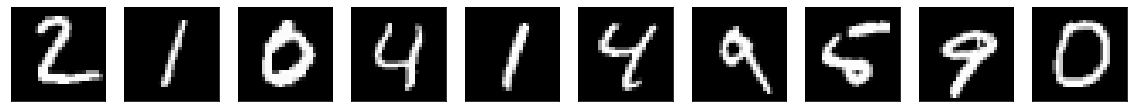

In [67]:
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(test_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#**Data Normalization and Flattening**

In [68]:
train_x = train_x.astype('float32') / 255.
test_x = test_x.astype('float32') / 255.

if convolutional_autoencoder is True: 
  train_x = np.reshape(train_x, (len(train_x), 28, 28, 1))
  test_x = np.reshape(test_x, (len(test_x), 28, 28, 1))
else: 
  train_x = train_x.reshape((len(train_x), np.prod(train_x.shape[1:])))
  test_x = test_x.reshape((len(test_x), np.prod(test_x.shape[1:])))

  if noisy_input is True: 
    train_x_n = train_x_n.reshape((len(train_x_n), np.prod(train_x_n.shape[1:])))
    test_x_n = test_x_n.reshape((len(test_x_n), np.prod(test_x_n.shape[1:])))

In [69]:
train_x.shape

(60000, 784)

In [70]:
test_x.shape

(10000, 784)

#**Autoencoders**

We start from the input image, then we have the "**encoded**" which is the encoded representation of the input and # "**decoded**" which is the lossy reconstruction of the input. After, we make a model mapping the input to its reconstruction and a model mapping the input to its **encoded representation**. Finally we retrieve the last layer of the **autoencoder** model and create the decoder model. We compile the **autoencoder** to use a per-pixel binary crossentropy loss, and the Adam optimizer. 



In [71]:
if convolutional_autoencoder is True: 
  input_img = Input(shape=(28, 28, 1))

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
else: 
  input_img = Input(shape=(784,))
  if deep_dense is True:
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
  else: 
    encoded = Dense(encoding_dim, activation='relu')(input_img)

  if deep_dense is True:
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
  else: 
    decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

if convolutional_autoencoder is False and deep_dense is False:
  encoder = Model(input_img, encoded)
  encoded_input = Input(shape=(encoding_dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_22 (Dense)            (None, 128)               100480    
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 784)               101

#**Autoencoder Training**

Since we **do not have** other that train_x and test_x in Unsupervised Training Sets, we train the Gradient Descent with **train_x as target**, in order to force the model to **reconstruct** the same input into the outpus as much as it can. Within the internal representations we will find an encoded and low dimensional description of the input data. Hence, we translate an **Unsupervised Task** into a purely **"Supervised" Regression** task and we need the loss (binary crossentropy) to estimate the quality of training, if it is decreasing over the epochs then the autoencoder is learning representations inside its 32 central neurons. 

In [72]:
if noisy_input is True: 
  X = train_x_n
  y = train_x
else:
  X = train_x
  y = train_x

autoencoder.fit(X, y, epochs=epochs, batch_size=256, shuffle=True, validation_data=(test_x, test_x))

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.2530 - val_loss: 0.2298
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1720 - val_loss: 0.1907
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1548 - val_loss: 0.1767
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1441 - val_loss: 0.1617
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1375 - val_loss: 0.1527
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1327 - val_loss: 0.1489
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1289 - val_loss: 0.1447
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1262 - val_loss: 0.1453
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1241 - val_loss: 0.1488
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1223 - val_loss: 0.1495

#**Autoencoder Inference**

We **encode** and **decode** some digits that are taken from **test** set, in 2 steps: from input to the central vector, and from the 32 central neurons to the output **reconstruction layer**


In [73]:
if noisy_input is True: 
  xt = test_x_n
else:
  xt = test_x

if convolutional_autoencoder is True or deep_dense is True: 
  decoded_imgs = autoencoder.predict(xt)
else: 
  encoded_imgs = encoder.predict(xt)
  decoded_imgs = decoder.predict(encoded_imgs)

#**Autoencoder Predictions Visualization**

With only 32 neurons the Autoencoder is able to reconstruct the Digits almost perfectly. This means that Autoencoder performed a compression, dimensionality reduction and clustering in one step !!

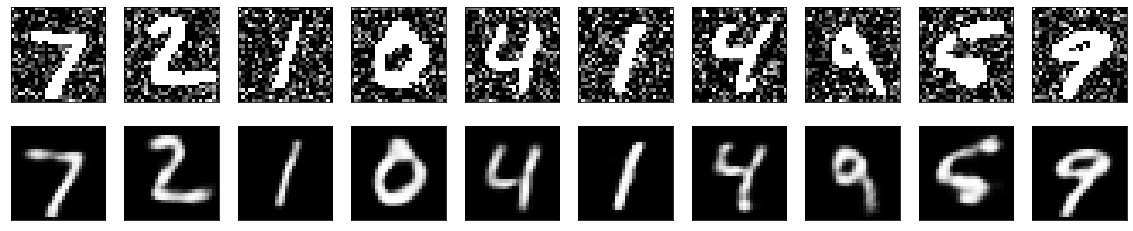

In [74]:
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xt[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# **Homeworks**

1) Optimize Denoising working on convolutions (i.e. reduce convolution layers and kernels) 

2) Plot internals of Convolutions with ALL Feature Maps Visualization and ALL Filters Visualization

3) Plot internal representation vector (32 neurons) and verify there is a Dimensionality Reduction and a Clustering on the Test set 

**Hint**: exploit labels on test set to colour all the activations of the internal neurons activations